# GACSE Workshop

In [1]:
from __future__ import print_function

In [2]:
import sys
sys.path.append('../build/')

In [3]:
%pylab inline
np.set_printoptions(precision=4, suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [4]:
import versor as vsr

In [5]:
from motor_estimation import MotorEstimationSolver

## Ground truth motor

In [11]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
print(motor)

Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]


## Motor Estimation from Points

### Dataset generation

In [61]:
n_points = 100000
sigma = 0.09
points_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null() 
            for i in range(n_points)]
points_b = [point.spin(motor) for point in points_a]
points_b_noisy = [vsr.Vec(*(np.array(point)[:3] 
                            + sigma * np.random.randn(3))).null() 
                  for point in points_b]

### Estimate motor

In [65]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(points_a, points_b):
    mes.add_point_correspondences_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(estimated_motor, summary) = mes.solve()
print(summary['full_report'])


Solver Summary (v 1.11.0-eigen-(3.2.6)-lapack-suitesparse-(4.4.4)-cxsparse-(3.1.4)-no_openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                        100000                   100000
Residual                               300000                   300000

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1

Cost:
Initial                          2.139857e+05


#### Check solution

In [29]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866 -0.    -0.5   -0.    -0.683 -0.433 -0.183 -0.25 ]
True


## Motor Estimation from Lines

### Dataset generation

In [66]:
lines_a = [vsr.Dll(vsr.Vec(*np.random.normal(0.0,0.8,3)),
                   vsr.Vec(*np.random.normal(0.0,0.8,3)))
          for i in range(10)]
lines_b = [line.spin(motor) for line in lines_a]

### Estimate motor using 6 residuals

$$ \arg \min_M \frac{1}{2} \sum_{i=1}^n \left| M \varLambda_{b_i} \tilde{M} - \varLambda_{a_i}  \right| $$

In [80]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
    mes.add_line_correspondences_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
estimated_motor, lin_summary_1 = mes.solve()
print(lin_summary_1['brief_report'])

Ceres Solver Report: Iterations: 5, Initial cost: 3.001520e+01, Final cost: 2.375385e-24, Termination: CONVERGENCE


#### Check solution

In [68]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866 -0.    -0.5   -0.    -0.683 -0.433 -0.183 -0.25 ]
True


### Estimate motor using 4 residuals

In [69]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
    mes.add_line_angle_distance_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
estimated_motor, lin_summary_2 = mes.solve()
print(lin_summary_2['brief_report'])

Ceres Solver Report: Iterations: 13, Initial cost: 2.662722e+01, Final cost: 1.250001e+00, Termination: CONVERGENCE


#### Check solution

In [70]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))
print(np.allclose(np.array(motor), np.array(estimated_motor), 
                  rtol=1e-05, atol=1e-03))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866  -0.     -0.5    -0.0003 -0.6831 -0.4331 -0.1827 -0.2499]
False
True


### Estimate motor using 2 residuals

In [71]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
    mes.add_line_angle_distance_norm_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
estimated_motor, lin_summary_3 = mes.solve()
print(lin_summary_3['brief_report'])

Ceres Solver Report: Iterations: 17, Initial cost: 2.662722e+01, Final cost: 1.250001e+00, Termination: CONVERGENCE


#### Check solution

In [85]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))
print(np.allclose(np.array(motor), np.array(estimated_motor), 
                  rtol=1e-05, atol=1e-03))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866 -0.    -0.5   -0.    -0.683 -0.433 -0.183 -0.25 ]
True
True


### Plots

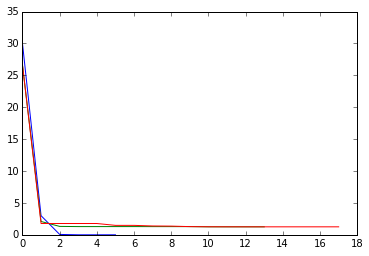

In [114]:
plt.figure(1)
# plt.subplot(311)
plt.plot([it['cost'] for it in lin_summary_1['iterations'] ])

# plt.subplot(312)
plt.plot([it['cost'] for it in lin_summary_2['iterations'] ])

# plt.subplot(313)
plt.plot([it['cost'] for it in lin_summary_3['iterations'] ])
plt.savefig('/Users/lars/Dropbox/Apps/ShareLaTeX/2016-gacse/figures/cost_lines.pdf')

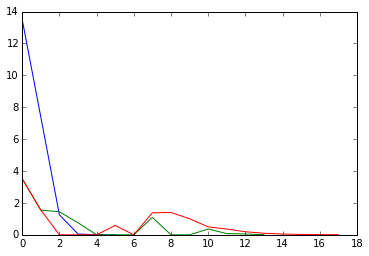

In [89]:
fig, ax = plt.subplots(1)
ax.plot([it['gradient_max_norm'] for it in lin_summary_1['iterations'] ])
ax.plot([it['gradient_max_norm'] for it in lin_summary_2['iterations'] ])
ax.plot([it['gradient_max_norm'] for it in lin_summary_3['iterations'] ])

## Motor Estimation from planes

### Dataset generation

In [48]:
n_planes = 10
planes_a = []
for i in range(10):
    dir_vec = np.random.normal(0.0, 0.8, 4)
    dir_vec = dir_vec / np.linalg.norm(dir_vec)
    distance = np.random.normal(0.0, 0.8,1)
    arr = dir_vec + distance
    planes_a.append(vsr.Dlp(dir_vec[0],dir_vec[1],dir_vec[2],distance[0]))
planes_b = [plane.spin(motor) for plane in planes_a]

### Estimate motor using 2 residuals

In [91]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
noise_motor_plane = vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(1,0,0) * np.pi/24)
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(planes_a, planes_b):
#     mes.add_dual_plane_angle_error_residual_block(a,b.spin(noise_motor_plane))
    mes.add_dual_plane_angle_error_residual_block(a,b)

mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
mes.function_tolerance = 1e-8
mes.max_num_iterations = 100
estimated_motor, pln_summary_1 = mes.solve()
print(pln_summary_2['brief_report'])

Ceres Solver Report: Iterations: 7, Initial cost: 2.889187e+01, Final cost: 1.250000e+00, Termination: CONVERGENCE


In [90]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))
print(np.allclose(np.array(motor), np.array(estimated_motor), 
                  rtol=1e-05, atol=1e-05))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866 -0.    -0.5   -0.    -0.683 -0.433 -0.183 -0.25 ]
True
True


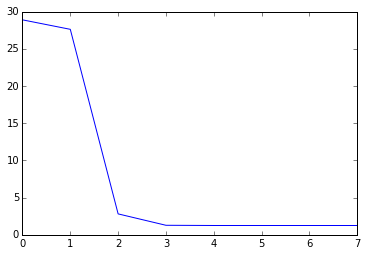

In [92]:
fig, ax = plt.subplots(1)
ax.plot([it['cost'] for it in pln_summary_1['iterations'] ])

## Motor Estimation from tangents

### Dataset generation

In [ ]:
n_tangents = 10
tangents_a = []
for i in range(n_tangents):
    dir_vec = np.random.normal(0.0, 0.8, 3)
    dir_vec = dir_vec / np.linalg.norm(dir_vec)
    pos = np.random.normal(0.0, 0.8, 3)
    tangents_a.append(vsr.Tnv(vsr.Vec(*dir_vec)).spin(vsr.Vec(*pos).trs() * 
                                             vsr.Rot(1,0,0,0)))

tangents_b = [tangent.spin(motor) for tangent in tangents_a]

### Estimate motors using flags

In [ ]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(tangents_a, tangents_b):
    dir_vec = np.random.normal(0.0, 0.8, 3)
    dir_vec = dir_vec / np.linalg.norm(dir_vec)
    pos = np.random.normal(0.0, 0.01, 3)
    angle = np.random.normal(0.0, pi/1000., 1)
    noise_motor_tangent = vsr.Vec(*pos).trs() * vsr.Rot(vsr.Vec(*dir_vec).unduale() * angle[0])
    b = b.spin(noise_motor_tangent)
    mes.add_point_correspondences_residual_block(a.pnt(), b.pnt())
    mes.add_line_correspondences_residual_block(a.lin().dual(), b.lin().dual())
#     mes.add_tangent_vector_point_angle_error_residual_block(a,b)

mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
mes.function_tolerance = 1e-8
mes.max_num_iterations = 200
em, summary = mes.solve()
print(motor)
print(em)
print(summary['brief_report'])

### Estimate motor

In [ ]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(tangents_a, tangents_b):
    mes.add_tangent_vector_point_angle_error_residual_block(a,b)

mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
mes.function_tolerance = 1e-8
mes.max_num_iterations = 2000
em, summary = mes.solve()
print(initial_motor)
print(motor)
print(em)
print(summary['full_report'])

## Motor Estimation from Circles

### Dataset generation

In [ ]:
n_circles = 5
circles_a = []
for i in range(n_circles):
    dir_vec = np.random.normal(0.0, 0.8, 3)
    dir_vec = dir_vec / np.linalg.norm(dir_vec)
    pos = np.random.normal(0.0, 0.8, 3)
    radius = np.random.normal(0.0, 0.8, 1)
    circles_a.append(vsr.Cir(vsr.Vec(*pos).null(), radius[0], 
                             vsr.Vec(*(dir_vec)).unduale()))

circles_b = [circle.spin(motor) for circle in circles_a]

### Estimate motor

In [ ]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(circles_a, circles_b):
#     mes.add_point_correspondences_residual_block(a.pnt(), b.pnt())
    mes.add_dual_plane_angle_error_residual_block(a.pln().dual(), b.pln().dual())

mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
mes.function_tolerance = 1e-6
mes.max_num_iterations = 2000
em, summary = mes.solve()
print(initial_motor)
print(motor)
print(em)
print(summary['full_report'])

## Motor Estimation from Spheres

### Dataset generation

In [ ]:
n_spheres = 5
spheres_a = []
for i in range(n_spheres):
    pos = np.random.normal(0.0, 0.8, 3)
    radius = np.random.normal(0.0, 0.8, 1)
    spheres_a.append(vsr.Sph(vsr.Vec(*pos).null(), radius[0]))
spheres_b = [sphere.spin(motor) for sphere in spheres_a]

### Estimate motor

In [ ]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(spheres_a, spheres_b):
    mes.add_point_correspondences_residual_block(a.pnt(),b.pnt())
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(estimated_motor, summary) = mes.solve()
print(summary['brief_report'])

## Motor Estimation from heterogeneous conformal objects

In [ ]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
noise_motor_plane = vsr.Vec(0.05,0.05,0.05).trs() * vsr.Rot(vsr.Biv(1,0,0) * np.pi/100)
noise_motor_lines = vsr.Vec(-0.01,-0.01,-0.01).trs() * vsr.Rot(vsr.Biv(0,1,0) * (-np.pi/100))
noise_motor_points = vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(0,0,1) * (np.pi/100))
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(planes_a, planes_b):
    mes.add_dual_plane_angle_error_residual_block(a,b.spin(noise_motor_plane))
for a, b in zip(lines_a, lines_b):
#     mes.add_line_angle_distance_residual_block(a, b.spin(noise_motor_lines))
    mes.add_line_correspondences_residual_block(a,b.spin(noise_motor_lines))
for a, b in zip(points_a, points_b):
    mes.add_point_correspondences_residual_block(a,b.spin(noise_motor_points))
for a, b in zip(tangents_a, tangents_b):
    mes.add_tangent_vector_point_angle_error_residual_block(a,b)


# for a, b in zip(points_a, points_b):
#     mes.add_point_correspondences_residual_block(a,b)
    
    

mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
mes.function_tolerance = 1e-8
mes.max_num_iterations = 100
em, summary = mes.solve()
print(initial_motor)
print(motor)
print(em)
print(summary['brief_report'])

## Hand Eye Calibration

### Set up motors

In [ ]:
M_object_in_world = vsr.Vec(1.0,1.0,0.1).trs() * vsr.Biv(pi/4.0, 0.0,0.0).exp()
M_eye_in_hand = vsr.Vec(0.1, 0.2, 0.3).trs() * vsr.Biv(0.0,1.0,0.0).exp()
M_eye_in_hand_initial = vsr.Vec(0.11, 0.24, 0.36).trs() * (vsr.Biv(1.0,1.0,0.0).unit() * (np.pi/5.)).exp()

### Dataset generation

In [ ]:
def hand_eye_pose_pairs(M_object_in_world, M_eye_in_hand, n):
    pose_pairs = [
            (M_hand_in_world, 
             (M_eye_in_hand.rev() * M_hand_in_world.rev() * M_object_in_world))
            for M_hand_in_world in [vsr.Vec(*np.random.rand(3)).trs() *
                                    vsr.Rot(vsr.Biv(*np.random.rand(3)).unit() *
                                            np.random.rand() * np.pi)
                                    for i in range(n)]]

    As = [pose_pair[0] for pose_pair in pose_pairs]
    Bs = [pose_pair[1] for pose_pair in pose_pairs]

    LAs = []
    LBs = []
    for i in range(n):
        for j in range(i+1,n):
            LAs.append(((As[j].rev() * As[i]).log() * 0.5).unit())
            LBs.append(((Bs[j] * Bs[i].rev()).log() * 0.5).unit())
    return LAs, LBs

In [ ]:
n_lines = 10
lines_a, lines_b = hand_eye_pose_pairs(M_object_in_world, M_eye_in_hand, n_lines)
print(len(lines_a))

### Estimate hand-eye motor 

In [ ]:
mes = MotorEstimationSolver(M_eye_in_hand_initial)
for a, b in zip(lines_a, lines_b):
    mes.add_line_angle_distance_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
mes.function_tolerance = 1e-16
estimated_motor, summary = mes.solve()
print(summary['full_report'])

#### Check solution

In [ ]:
print(np.array(M_eye_in_hand))
print(np.array(estimated_motor))
print(np.allclose(np.array(M_eye_in_hand), np.array(estimated_motor)))

### Real Experiment

In [ ]:
import cPickle as pickle
import math3d as m3d

#### Dataset generation

In [ ]:
rob_pose_list = pickle.load(open('pose_list.dump'))
obj_pose_list = pickle.load(open('obj_pose_list.dump'))
a_trfs = pickle.load(open('as.dump'))
b_trfs = pickle.load(open('bs.dump'))

In [ ]:
rob_motors = [vsr.Vec(*pos).trs() * vsr.Rot(vsr.Vec(*axis).unduale() * angle / 2.)
              for pos, (axis, angle) in [(m3d.Transform(pose).pos, 
                                          m3d.Transform(pose).orient.axis_angle)
                                         for pose in rob_pose_list]]
obj_motors = [vsr.Vec(*pos).trs() * vsr.Rot(vsr.Vec(*axis).unduale() * angle / 2.)
              for pos, (axis, angle) in [(m3d.Transform(pose).pos, 
                                          m3d.Transform(pose).orient.axis_angle)
                                         for pose in obj_pose_list]]

In [ ]:
n_lines = len(rob_motors)
lines_a = []
lines_b = []
for i in range(n_lines):
    for j in range(i+1,n_lines):
        lines_a.append(((rob_motors[j].rev() * rob_motors[i]).log() * 0.5).unit())
        lines_b.append(((obj_motors[j].rev() * obj_motors[i]).log() * 0.5).unit())

In [ ]:
n_lines = len(a_trfs)
motors_a = [vsr.Vec(*pos).trs() * vsr.Rot(vsr.Vec(*axis).unduale() * angle / 2.)
              for pos, (axis, angle) in [(m3d.Transform(pose).pos, 
                                          m3d.Transform(pose).orient.axis_angle)
                                         for pose in a_trfs]]
motors_b = [vsr.Vec(*pos).trs() * vsr.Rot(vsr.Vec(*axis).unduale() * angle / 2.)
              for pos, (axis, angle) in [(m3d.Transform(pose).pos, 
                                          m3d.Transform(pose).orient.axis_angle)
                                         for pose in b_trfs]]
lines_a = [motor.log() for motor in motors_a]
lines_b = [motor.log() for motor in motors_b]

#### Estimate hand-eye motor

In [ ]:
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
    mes.add_line_correspondences_residual_block(b,a)
#     mes.add_line_angle_distance_residual_block(b,a)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
mes.max_num_iterations = 25
mes.function_tolerance = 1e-12
estimated_motor, summary = mes.solve()
print(summary['full_report'])

In [ ]:
print(estimated_motor)
print(m3d.Transform(estimated_motor.matrix()))

#### Combination of estimates

In [ ]:
bivectors = [np.array((r * estimated_motor * o.rev()).log()) 
             for r, o in zip(rob_motors, obj_motors)]
m = vsr.Dll(*np.average(bivectors,0)).exp()
print(m3d.Transform(m.matrix()))

#### Tsai Lenz Solver

In [ ]:
from tsai_lens_calibration import TsaiLenzCalibrator

In [ ]:
pose_pairs = [(m3d.Transform(A), m3d.Transform(B)) 
              for (A, B)  in zip(rob_pose_list, obj_pose_list)]
tsai_lens = TsaiLenzCalibrator(pose_pairs)
tsai_lens.sensor_in_flange

#### Park Martin Solver

In [ ]:
from park_martin import calibrate as park_martin_calibration
A, B = [], []
n_trfs = len(rob_pose_list)
for i in range(n_trfs):
    for j in range(i+1, n_trfs):
        A.append((m3d.Transform(rob_pose_list[j]).inverse * m3d.Transform(rob_pose_list[i])).array)
        B.append((m3d.Transform(obj_pose_list[j]).inverse * m3d.Transform(obj_pose_list[i])).array)
R,t = park_martin_calibration(A,B)
print(m3d.Transform(R,t))

In [ ]:
def daniilidis(LAs, LBs):
    def skew(v):
        skv = roll(roll(diag(v.flatten()), 1, 1), -1, 0)
        return skv - skv.T
    
    Ds = []
    for LA, LB in zip(LAs, LBs):
        LA = LA.unit()
        LB = LB.unit()
        D = np.zeros((6,8))
        a = np.array(LA).copy()[:3]
        a = np.array([a[2], -a[1], a[0]])
        b = np.array(LB).copy()[:3]
        b = np.array([b[2], -b[1], b[0]])
        aprime = np.array(LA).copy()[3:]
        bprime = np.array(LB).copy()[3:]
        # Upper 3
        D[:3,0] = a - b
        D[:3,1:4] = skew(a + b)
        # Lower 3
        D[3:,0] = aprime - bprime
        D[3:,1:4] = skew(aprime + bprime)
        D[3:,4] = a - b 
        D[3:,5:8] = skew(a + b)  
        Ds.append(D)
    Ds = np.array(Ds).reshape(-1,8)
    
    [U, s, Vt] = np.linalg.svd(Ds)
    v7 = Vt.T[:,-2]
    v8 = Vt.T[:,-1]
    u1 = v7[:4]
    v1 = v7[4:]
    u2 = v8[:4]
    v2 = v8[4:]
    
    a = np.inner(u1,v1)
    b = np.inner(u1,v2) + np.inner(u2,v1)
    c = np.inner(u2,v2)
    [s1, s2] = np.roots([a,b,c])
    
    val1 = (s1**2 * np.inner(u1,u1)) + (2 * s1 * np.inner(u1,u2)) + (np.inner(u2,u2))
    val2 = (s2**2 * np.inner(u1,u1)) + (2 * s2 * np.inner(u1,u2)) + (np.inner(u2,u2))

    if val1 > val2:
        s = s1
        val = val1
    else:
        s = s2
        val = val2

    lambda2 = np.sqrt(1./val)
    lambda1 = s * lambda2
    
    m_arr = lambda1 * v7 + lambda2 * v8
    m_arr[1:4] = np.array([m_arr[3], -m_arr[2], m_arr[1]])
    m_arr[4:8] = np.roll(m_arr[4:8], -1)
    
    print(Ds)
    
    return vsr.Mot(*m_arr)

In [ ]:
daniilidis_motor = daniilidis(lines_b, lines_a)

In [ ]:
print(m3d.Transform(daniilidis_motor.matrix()))

In [ ]:
print(estimated_motor * estimated_motor.rev())
print(daniilidis_motor * daniilidis_motor.rev())

In [ ]:
bivectors = [np.array((r * daniilidis_motor * o.rev()).log()) 
             for r, o in zip(rob_motors, obj_motors)]
m = vsr.Dll(*np.average(bivectors,0)).exp()
print(m3d.Transform(m.matrix()))